In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

import pickle
import sklearn
import time
from sklearn import metrics
from sklearn import model_selection
from sklearn.metrics import multilabel_confusion_matrix

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [2]:
%run SharedFunctions.ipynb

Učitava se prethodno pripremljen skup podataka: 

In [3]:
data = pd.read_csv('data/data_longer.csv')
data.drop(columns=['Unnamed: 0'], inplace=True)

U ovom slučaju, koristi se samo deo podataka koji ima neku labelu, tj. samo toksični komentari. Njih je potrebno klasifikovati u 6 različitih klasa (sa preklapanjem).

In [4]:
labels = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']
data = data[data['target'] == 1]

In [5]:
data.head()

,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,target,word_count
6,cocksucker before you piss around on my work,1,1,1,0,1,0,1,8
12,hey what is it talk what is it an exclusive...,1,0,0,0,0,0,1,50
16,bye dont look come or think of comming back ...,1,0,0,0,0,0,1,10
42,you are gay or antisemmitian archangel white...,1,0,1,0,1,1,1,109
43,fuck your filthy mother in the ass dry,1,0,1,0,1,0,1,8


In [6]:
data.shape

(22468, 9)

Dakle, broj instanci za višelabelarnu klasifikaciju je 22468

In [7]:
# prosecan broj reci po komentaru

data['word_count'].mean()

48.906044151682394

### 1. Podela na trening, test, i validacioni skup

In [8]:
X = data['comment_text']
y = data[labels]

X_train_validation, X_test, y_train_validation, y_test = \
    model_selection.train_test_split(X, y, test_size=0.33, random_state=7)

X_train, X_validation, y_train, y_validation =\
    model_selection.train_test_split(X_train_validation, y_train_validation, test_size=0.2, random_state=7)

 train_test_split izbacuje gresku
 ValueError: The least populated class in y has only 1 member, 
 which is too few. The minimum number of groups for any class cannot be less than 2.

 X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.33, random_state=7, stratify=y)

In [9]:
# RUCNO:

In [10]:
#test_size = int(0.3 * data.shape[0])
#train_size = data.shape[0] - test_size
#validation_size = int(0.2 * train_size)
#train_size -= validation_size

In [11]:
#train_data = data[:train_size]
#validation_data = data[train_size : train_size + validation_size]
#test_data = data[train_size+validation_size: ]

In [12]:
#X_train = train_data['comment_text']
#X_validation = validation_data['comment_text']
#X_test = test_data['comment_text']

#y_train = train_data[labels]
#y_test = test_data[labels]
#y_validation = validation_data[labels]

In [13]:
label_counts = {}
for label in labels:
    label_counts[label] = (y_test[y_test[label]==1].shape[0])

### 2. Tokenizacija I vektorizacija teksta

In [14]:
# uzima se recimo 20000 najfrekventinijh reci
max_features = 10000

# max duzina
max_len = 50

In [15]:
word_index, tokenizer = get_vocabulary(max_features, X_train, 'tokenizer_multi.pickle')

In [16]:
print('Broj jedinstvenih reci:', len(word_index))

Broj jedinstvenih reci: 31529


In [17]:
X_train = to_sequence(X_train, max_len, tokenizer)
X_test = to_sequence(X_test, max_len, tokenizer)
X_validation = to_sequence(X_validation, max_len, tokenizer)

In [18]:
X_train.shape, X_test.shape, X_validation.shape

((12042, 50), (7415, 50), (3011, 50))

In [19]:
# kreiranje matrice ugnjezdjavanja

embedding_matrix = create_embedding_matrix(word_index, max_len)

### 3. Formiranje modela

Odmah se prelazi na formiranje modela, parametre izabrani isprobavanjem

In [20]:
kernel_size = 3
pool_size = 4
filters = 64
dropout_rate = 0.2
embedding_dim = 50
lr = 0.001
layers = 0

In [21]:
multi_model = create_model(num_of_classes = 6, num_of_features = max_features, embedding_dim = embedding_dim, 
                           kernel_size = kernel_size, pool_size = pool_size, filters = filters, 
                           dropout_rate = dropout_rate, maxlen = max_len, lr = lr, 
                           embedding_matrix = embedding_matrix, layers=layers)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 50, 50)            500000    
_________________________________________________________________
conv1d (Conv1D)              (None, 50, 64)            9664      
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 12, 64)            0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 12, 128)           24704     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 3, 128)            0         
_________________________________________________________________
dropout (Dropout)            (None, 3, 128)            0         
_________________________________________________________________
global_average_pooling1d (Gl (None, 128)               0

### 4. Obučavanje modela

In [22]:
# TODO weights

In [23]:
weights = get_weights(data[labels].to_numpy(), 6)
weights

{0: 0.17511535104127696,
 1: 1.90859667006456,
 2: 0.3084568918176826,
 3: 5.43492985002419,
 4: 0.3312691672564284,
 5: 1.7688552983782082}

In [24]:
epochs = 15
batch_size = 64

In [25]:
start = time.time()    

multi_history = multi_model.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, 
                                validation_data=(X_validation, y_validation),
                                class_weight=weights)
                                 
print('Trajanje obucavanja modela multilabel klasifikacije: ', time.time() - start)

Epoch 1/15
189/189 [==============================] - 3s 7ms/step - loss: 0.0875 - accuracy: 0.9296 - f1_m: 0.7550 - val_loss: 0.3605 - val_accuracy: 0.9545 - val_f1_m: 0.7773
Epoch 2/15
189/189 [==============================] - 1s 5ms/step - loss: 0.0765 - accuracy: 0.9442 - f1_m: 0.7794 - val_loss: 0.3440 - val_accuracy: 0.9508 - val_f1_m: 0.7856
Epoch 3/15
189/189 [==============================] - 1s 5ms/step - loss: 0.0729 - accuracy: 0.9420 - f1_m: 0.7864 - val_loss: 0.3398 - val_accuracy: 0.9256 - val_f1_m: 0.7897
Epoch 4/15
189/189 [==============================] - 1s 5ms/step - loss: 0.0701 - accuracy: 0.9316 - f1_m: 0.7924 - val_loss: 0.3315 - val_accuracy: 0.9229 - val_f1_m: 0.7886
Epoch 5/15
189/189 [==============================] - 1s 5ms/step - loss: 0.0678 - accuracy: 0.9203 - f1_m: 0.7950 - val_loss: 0.3295 - val_accuracy: 0.9382 - val_f1_m: 0.7774
Epoch 6/15
189/189 [==============================] - 1s 5ms/step - loss: 0.0660 - accuracy: 0.9143 - f1_m: 0.7987 - val

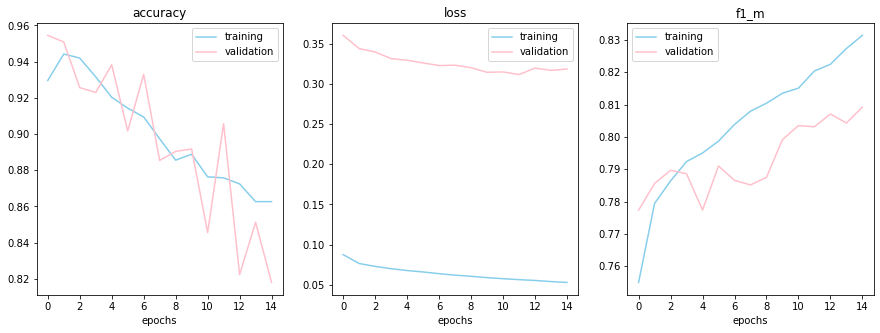

In [26]:
plot_graphs(multi_history, ['accuracy', 'loss', 'f1_m'])

### 5. Evaluacija modela

In [27]:
scores = multi_model.evaluate(X_test, y_test)
print('Loss: ', scores[0])
print('Test accuracy: ', scores[1])
print('F1: ', scores[2])

232/232 [==============================] - 0s 2ms/step - loss: 0.3219 - accuracy: 0.8189 - f1_m: 0.8082
Loss:  0.32186058163642883
Test accuracy:  0.8188806176185608
F1:  0.8082356452941895


Predviđanje:

In [28]:
y_predicted = multi_model.predict(X_test)

In [29]:
y_labels = y_predicted.round()

In [30]:
cf = multilabel_confusion_matrix(y_test, y_labels)

In [31]:
label_counts

{'toxic': 7058,
 'severe_toxic': 649,
 'obscene': 3976,
 'threat': 236,
 'insult': 3709,
 'identity_hate': 735}

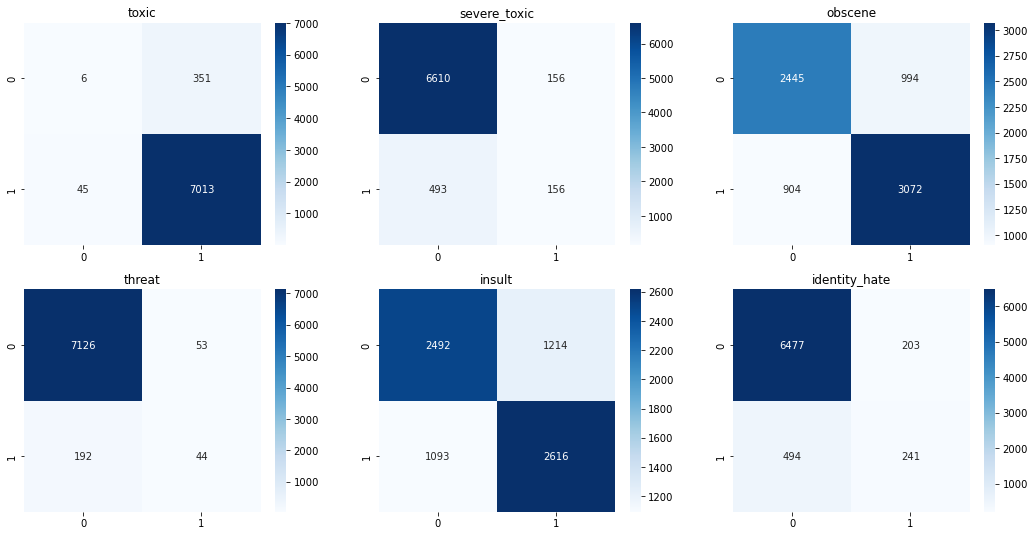

In [32]:
plot_cf(cf, 'multi', labels)

In [33]:
print('---------------------- IZVESTAJ -----------------------\n')
print(metrics.classification_report(y_test, y_labels,
      target_names=labels))

---------------------- IZVESTAJ -----------------------

               precision    recall  f1-score   support

        toxic       0.95      0.99      0.97      7058
 severe_toxic       0.50      0.24      0.32       649
      obscene       0.76      0.77      0.76      3976
       threat       0.45      0.19      0.26       236
       insult       0.68      0.71      0.69      3709
identity_hate       0.54      0.33      0.41       735

    micro avg       0.82      0.80      0.81     16363
    macro avg       0.65      0.54      0.57     16363
 weighted avg       0.80      0.80      0.80     16363
  samples avg       0.83      0.84      0.79     16363



C:\Users\panap\anaconda3\envs\envi\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
